In [33]:
import torch

from plot import *
from constants import MEANS, STDS
from maths import me, mae, mse, rmse
from fft import *

In [2]:
VARIABLE = "V"

if VARIABLE == "U":
    model = torch.load("FNN/U-1024-512-256-LeakyReLU-NGCTCC-hardy-bee-540")
else:
    model = torch.load("FNN/V-1024-512-256-LeakyReLU-NGCTCC-radiant-wave-1")
model.eval()

Sequential(
  (0): Linear(in_features=19, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=1, bias=True)
)

In [3]:
LAT_RESOLUTION = 361
LON_RESOLUTION = 576
TIME_RESOLUTION = 8 * 365

In [4]:
lev = 35
time = 0

lat, lon = np.meshgrid(np.linspace(-90, 90, LAT_RESOLUTION, endpoint=False),
                       np.linspace(-180, 180, LON_RESOLUTION, endpoint=False))
lat = lat.flatten()
lon = lon.flatten()

df = pd.DataFrame({"lev": lev / 36, "lat": lat / 90, "lon": lon / 180, "time": time,
                   "lat_i": (lat + 90) // 0.5, "lon_i": (lon + 180) // 0.625}, dtype="float16")

del time, lat, lon

df["day %"] = (df["time"] % 8) / 8
df["year %"] = (df["time"] / 2920).astype("float16")
del df["time"]

df["sin_day"] = np.sin(df["day %"] * np.pi * 2)
df["cos_day"] = np.cos(df["day %"] * np.pi * 2)
df["sin_year"] = np.sin(df["year %"] * np.pi * 2)
df["cos_year"] = np.cos(df["year %"] * np.pi * 2)

df["sin_lat"] = np.sin(df["lat"] * np.pi)
df["cos_lat"] = np.cos(df["lat"] * np.pi)
df["sin_lon"] = np.sin(df["lon"] * np.pi)
df["cos_lon"] = np.cos(df["lon"] * np.pi)

frland = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLAND",
                                         time=0, level=0, folder="../data/raw").astype("float16")
frocean = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FROCEAN",
                                          time=0, level=0, folder="../data/raw").astype("float16")
frlake = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLAKE",
                                         time=0, level=0, folder="../data/raw").astype("float16")
frlandice = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="FRLANDICE",
                                            time=0, level=0, folder="../data/raw").astype("float16")
phis = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="PHIS",
                                       time=0, level=0, folder="../data/raw")
sgh = load_variable_at_time_and_level("MERRA2_101.const_2d_asm_Nx.00000000.nc4", variable="SGH",
                                      time=0, level=0, folder="../data/raw")

phis -= phis.mean()
phis /= phis.std()
phis = phis.astype("float16")

sgh -= sgh.mean()
sgh /= sgh.std()
sgh = sgh.astype("float16")

indices = df[["lat_i", "lon_i"]].values.T.astype("int16")

del df["lat_i"], df["lon_i"]

df["frland"] = frland[*indices]
df["frocean"] = frocean[*indices]
df["frlake"] = frlake[*indices]
df["frlandice"] = frlandice[*indices]
df["phis"] = phis[*indices]
df["sgh"] = sgh[*indices]

del indices, sgh, phis, frland, frlake, frocean, frlandice

df.head()

,lev,lat,lon,day %,year %,sin_day,cos_day,sin_year,cos_year,sin_lat,cos_lat,sin_lon,cos_lon,frland,frocean,frlake,frlandice,phis,sgh
0,0.972168,-1.000000,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.000968,-1.000000,-0.000968,-1.0,0.0,0.0,0.0,1.0,2.865234,-0.210815
1,0.972168,-0.994629,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.018539,-1.000000,-0.000968,-1.0,0.0,0.0,0.0,1.0,2.865234,-0.210815
2,0.972168,-0.988770,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.036102,-0.999512,-0.000968,-1.0,0.0,0.0,0.0,1.0,2.953125,-0.190430
3,0.972168,-0.983398,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.053680,-0.998535,-0.000968,-1.0,0.0,0.0,0.0,1.0,3.080078,-0.242798
4,0.972168,-0.978027,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.069275,-0.997559,-0.000968,-1.0,0.0,0.0,0.0,1.0,3.197266,-0.288818


In [14]:
predictions = []

for time in tqdm(range(0, 8 * 365)):
    df["day %"] = (time % 8) / 8
    df["year %"] = time / 2920

    df["sin_day"] = np.sin(df["day %"] * np.pi * 2)
    df["cos_day"] = np.cos(df["day %"] * np.pi * 2)
    df["sin_year"] = np.sin(df["year %"] * np.pi * 2)
    df["cos_year"] = np.cos(df["year %"] * np.pi * 2)

    with torch.no_grad():
        prediction = model(torch.tensor(df.values, device="mps", dtype=torch.float32))
    prediction = np.array((prediction.reshape((LON_RESOLUTION, LAT_RESOLUTION)).T * STDS[VARIABLE] + MEANS[VARIABLE]).cpu(), dtype="float16")
    predictions.append(prediction)
    del prediction

predictions = np.array(predictions)

  0%|          | 0/2920 [00:00<?, ?it/s]

In [16]:
filename = "MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4"
data = load_variable_at_level(filename, VARIABLE, lev, folder="../data")

error = data - predictions

lines = f"""
    Original Stdev: {data.astype('float32').std()} m/s
    Predicted ME:  {me(data, predictions)} m/s
    Predicted MAE:  {mae(data, predictions)} m/s
    Predicted RMSE: {rmse(data, predictions)} m/s
    """
print(lines)

  0%|          | 0/12 [00:00<?, ?it/s]


    Original Stdev: 3.1836330890655518 m/s
    Predicted ME:  -0.0212860107421875 m/s
    Predicted MAE:  1.0068359375 m/s
    Predicted RMSE: 1.353525489231732 m/s
    


In [31]:
error_fft = dft3_at_level(error, lev, quantile=0.999, cache=False)
error_prediction, error_freqs = idft3_at_level(*error_fft)

fft = dft3_at_level(data, lev, quantile=0.999, cache=False)
dft_prediction, dft_freqs = idft3_at_level(*fft)

corrected_pred = predictions + error_prediction

lines = f"""
    Fourier Size: {sum(el.nbytes for el in fft) * 36 / (1000 ** 2)} MB
    Fourier ME:  {me(data, dft_prediction)} m/s
    Fourier MAE:  {mae(data, dft_prediction)} m/s
    Fourier RMSE: {rmse(data, dft_prediction)} m/s

    Corrected Size: {sum(el.nbytes for el in error_fft) * 36 / (1000 ** 2) + 14.6} MB
    Corrected ME:  {me(data, corrected_pred)} m/s
    Corrected MAE:  {mae(data, corrected_pred)} m/s
    Corrected RMSE: {rmse(data, corrected_pred)} m/s
    """
print(lines)


    Fourier Size: 44.554716 MB
    Fourier ME:  -3.392534477907405e-05 m/s
    Fourier MAE:  0.38089601088215885 m/s
    Fourier RMSE: 0.5010174541629064 m/s

    Corrected Size: 59.58344 MB
    Corrected ME:  -1.563797973442475e-06 m/s
    Corrected MAE:  0.46850599349923394 m/s
    Corrected RMSE: 0.6286780832263954 m/s
    


In [29]:
dft_freqs, error_freqs

(30465, 30465)

In [37]:
size = 0

mae_loss = 0
mse_loss = 0


for time in tqdm(range(8 * 365)):
    error_fft = dft2_at_time_and_level(error[time], quantile=0.999)
    error_prediction, error_freqs = idft2_at_time_and_level(*error_fft)
    size += sum(el.nbytes for el in error_fft) * 36 / (1000 ** 2)

    data_slice = data[time]
    corrected_pred = predictions[time] + error_prediction

    mae_loss += mae(data_slice, corrected_pred)
    mse_loss += mse(data_slice, corrected_pred)


lines = f"""
    2D Corrected Size: {size + 14.6} MB

    2D Corrected MAE:  {mae_loss / 2920} m/s
    2D Corrected RMSE: {(mse_loss / 2920) ** 0.5} m/s
    """
print(lines)

  0%|          | 0/2920 [00:00<?, ?it/s]


    2D Corrected Size: 70.77321199999953 MB

    2D Corrected MAE:  0.7617637299449076 m/s
    2D Corrected RMSE: 3.305460332475266 m/s
    


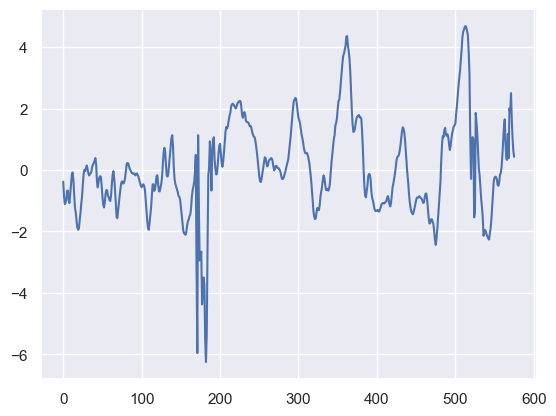

In [42]:
plt.plot(error[0, 100])

Text(0.5, 1.0, 'Squared Error (m²/s²)')

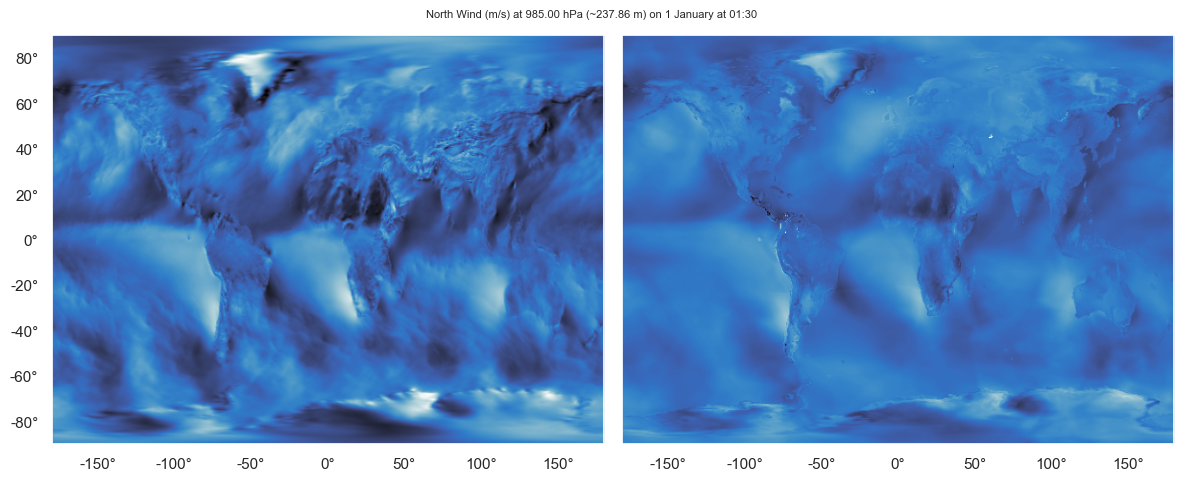

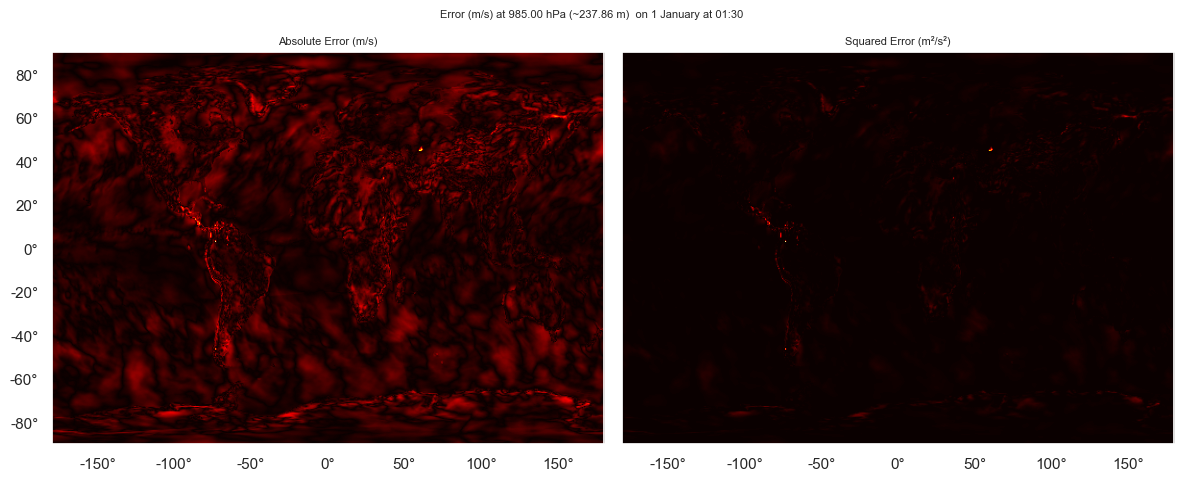

In [7]:
filename = "MERRA2.tavg3_3d_asm_Nv.YAVG0101.nc4"
data = load_variable_at_time_and_level(filename, VARIABLE, time, lev, folder="../data")

title = f"{format_variable(VARIABLE)} at {format_level(lev)}" \
        f" on {format_date(filename)} at {format_time(time, filename)}"

fig, ax1, ax2 = create_1x2_plot(title, sharey=True, sharex=True)
ax1.imshow(data, cmap=cmr.arctic, origin="lower", extent=[-180, 180, -90, 90], aspect="auto")
ax2.imshow(prediction, cmap=cmr.arctic, origin="lower", extent=[-180, 180, -90, 90], aspect="auto")

ax1.grid(False)
ax2.grid(False)

ax1.xaxis.set_major_formatter(FormatStrFormatter("%d°"))
ax1.yaxis.set_major_formatter(FormatStrFormatter("%d°"))

fig.suptitle(title, fontsize=8, y=0.96)

title = f"Error ({get_units_from_variable(VARIABLE)}) at {format_level(lev)} " \
        f" on {format_date(filename)} at {format_time(time, filename)}"

error = data - prediction

fig, ax1, ax2 = create_1x2_plot(title, sharey=True, sharex=True)
ax1.imshow(np.abs(error), cmap="hot", origin="lower", extent=[-180, 180, -90, 90], aspect="auto")
ax2.imshow(error ** 2, cmap="hot", origin="lower", extent=[-180, 180, -90, 90], aspect="auto")

ax1.grid(False)
ax2.grid(False)

ax1.xaxis.set_major_formatter(FormatStrFormatter("%d°"))
ax1.yaxis.set_major_formatter(FormatStrFormatter("%d°"))

fig.suptitle(title, fontsize=8, y=0.96)
ax1.set_title("Absolute Error (m/s)", fontsize=8)
ax2.set_title("Squared Error (m²/s²)", fontsize=8)

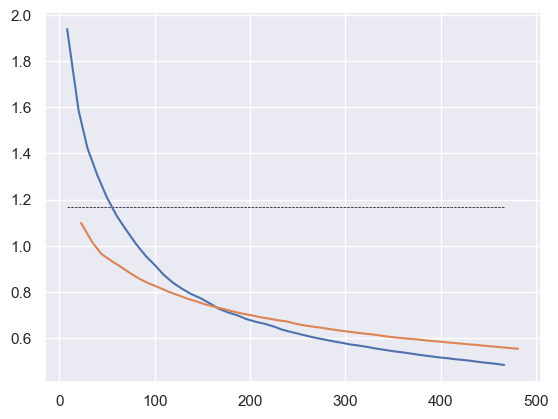

In [29]:
from fft import dft2_at_time_and_level, idft2_at_time_and_level

mlp_errors = [np.abs(prediction - data).mean()] * 50

dft_errors = []
dft_sizes = []
mlp_dft_errors = []
mlp_dft_sizes = []

quantiles = np.linspace(0.99, 0.9999, 50)

for quantile in quantiles:
    fft = dft2_at_time_and_level(error, quantile=quantile)
    error_prediction, _ = idft2_at_time_and_level(*fft)

    fft = dft2_at_time_and_level(data, quantile=quantile)
    dft_prediction, freqs = idft2_at_time_and_level(*fft)

    corrected_pred = prediction + error_prediction

    dft_errors.append(np.abs(dft_prediction - data).mean())
    mlp_dft_errors.append(np.abs(corrected_pred - data).mean())
    dft_sizes.append(sum(el.nbytes for el in fft) * 36 * 8 * 365 / (1000 ** 2))
    mlp_dft_sizes.append(sum(el.nbytes for el in fft) * 36 * 8 * 365 / (1000 ** 2) + 5.2)

    # lines = f"""
    #          MAE MLP: {} m/s
    #       MAE 3D DFT: {} m/s
    #     MAE MLP + FT: {} m/s
    #
    #     Frequencies: {freqs}
    #     Size: {sum(el.nbytes for el in fft) * 36 * 8 * 365 / (1000 ** 2) + 14.6} MB
    # """
    # print(lines)

plt.plot(dft_sizes, mlp_errors, c="#000", linestyle="dashed", linewidth=0.5)
plt.plot(dft_sizes, dft_errors)
plt.plot(mlp_dft_sizes, mlp_dft_errors)